In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
dataset = datasets.fetch_california_housing(as_frame = True)
import numpy as np
# print(dataset.frame.DESCR)

import matplotlib.pyplot as plt
import seaborn as sns

## Question 1: 
- Load an original dataset, 
- comment on this dataset (what are the features, the dimensions of the problem, 
- how does the correlation matrix looks like)

We choose to work with the California Housing Dataset from sklearn as this is a real-world, but still relatively clean, dataset and needs little preprocessing. The set has 20640 entries of 9 variables each

In [2]:
print(f"Shape: {dataset.frame.shape}")

Shape: (20640, 9)


Number of Attributes: 8 numeric, predictive attributes and the target

Attribute Information:
- MedInc        median income in block group
- HouseAge      median house age in block group
- AveRooms      average number of rooms per household
- AveBedrms     average number of bedrooms per household
- Population    block group population
- AveOccup      average number of household members
- Latitude      block group latitude
- Longitude     block group longitude

Consider some summary statistics for each feature:

In [3]:
dataset.frame.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


The AveRooms column lists the maximum as 141.9. Even billionaires don't often have an average of 141 rooms in their mansions, so we investigate the existence of outliers.

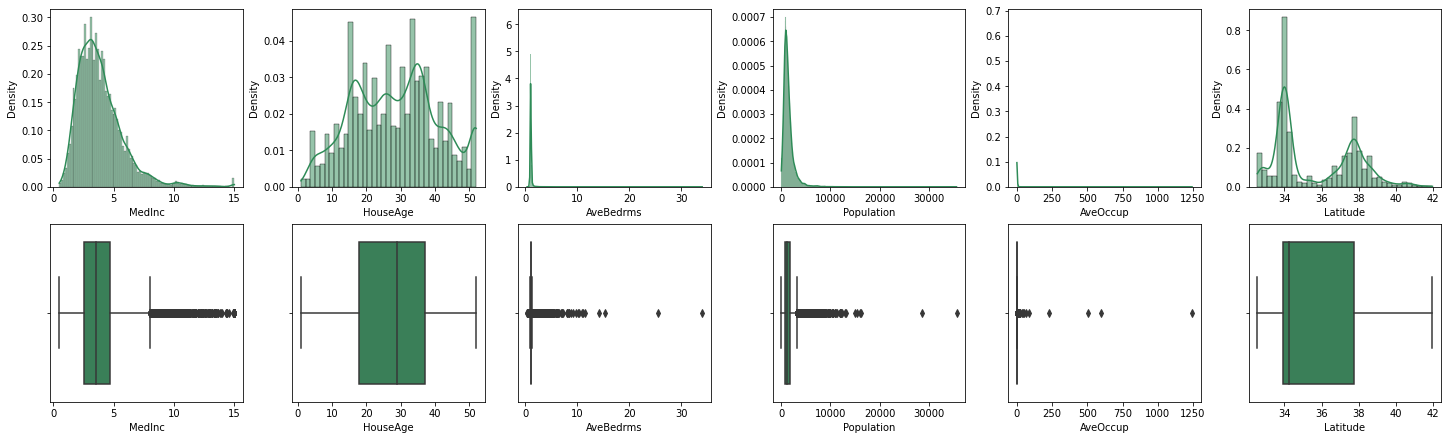

In [4]:
substudy = dataset.frame.drop(["Longitude", "AveRooms"], axis=1)
colsub = substudy.columns
fig, ax = plt.subplots(2, 6, constrained_layout=True, figsize=(20, 6))
for i in range(len(colsub)-1):
    sns.histplot(data = substudy, x= colsub[i], ax = ax[0, i], stat = "density", kde = True, color='seagreen')
    sns.boxplot(data=substudy, x=colsub[i], ax=ax[1, i], color='seagreen');

There are also definitely outliers present in the data. Except for these, the features seem to broadly be distibuted as Gaussians, with the exception of the geographical information which is bimodal and perhaps rather a mixture.

To this end, we remove the 99.9 percentile, which removes very few entries but gets rid of the most extreme outliers.

In [5]:
cols = dataset.frame.columns
dfnew = dataset.frame.copy()
for i in range(len(cols)-1):
    dfnew = dfnew[dfnew[cols[i]] < dfnew[cols[i]].quantile(.999)]
print(f"Removal of {np.round((len(dataset.frame)-len(dfnew))/len(dataset.frame), 3)}% of entries", )
dataset = dfnew

Removal of 0.069% of entries


We now consider the correlation matrix

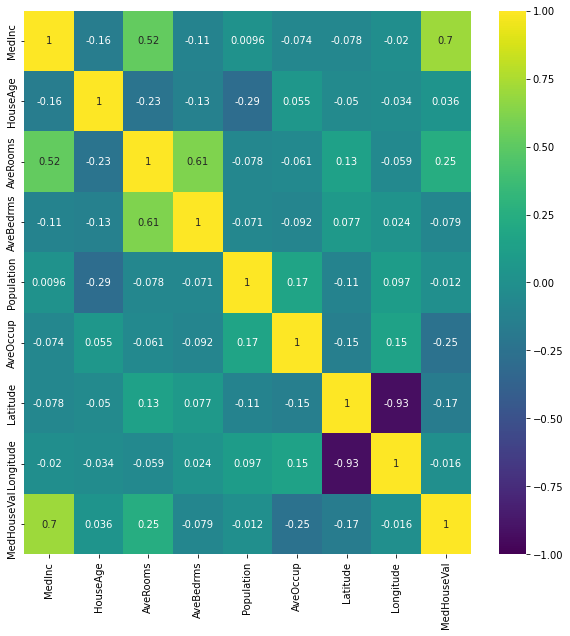

In [6]:
plt.figure(figsize=(10, 10))
cor_matrix = sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True, cmap = sns.color_palette('viridis', as_cmap=True))

Except for two pairs of variables (Lat and Long, AveRooms and AveBdrms), there seems to be no strong correlation between the variables. 
Let us further explore the relationship between these two pairs.

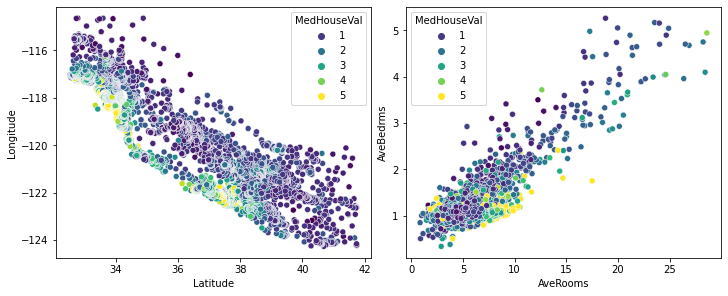

In [7]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
sns.scatterplot(data=dataset, x=cols[-3], y=cols[-2], hue=cols[-1], palette= sns.color_palette('viridis', as_cmap=True), ax=ax[0]);
sns.scatterplot(data=dataset, x=cols[2], y=cols[3], hue=cols[-1], palette= sns.color_palette('viridis', as_cmap=True), ax=ax[1]);

The data here represents housing information from California, which is a state on the West Coast of the US; the geography of the area considered explains the almost linear relationship between the 2 geographical features as it is immediately obvious that homes along the coast tend to be more expensive. 

We also note that there is a strong positive correlation between the 2nd pair of variables. It seems that homes with a higher Rooms-to-Bedrooms proportion tend to be more expensive. This also makes sense as it would allow for alternatives such as sitting rooms and dining rooms to be included.

We now consider the relationship of the features w.r.t the y-label

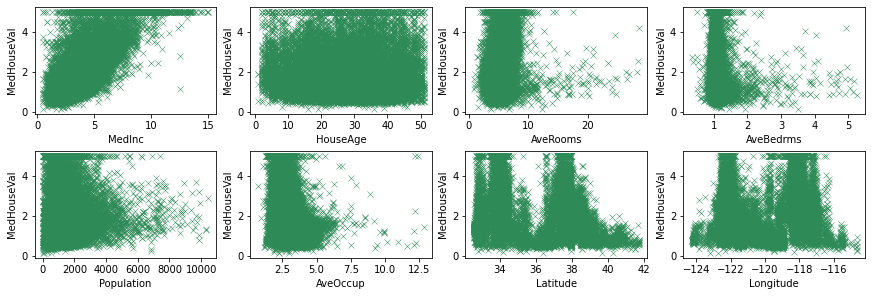

In [8]:
cols = dataset.columns
fig, (ax1, ax2) = plt.subplots(2, 4, constrained_layout=True, figsize=(12, 4))
for i in range(4):
  sns.scatterplot(data = dataset, x = cols[i], y = cols[-1], marker="x", ax = ax1[i], color='seagreen')
  sns.scatterplot(data = dataset, x = cols[i+4], y = cols[-1], marker="x", ax = ax2[i], color='seagreen')

As mentioned before, the geographical features seem to be bimodal. Finally, consider the distribution of the label, Median House Value which seems to be broadly follow a Poisson distribution, but with a single outlying mode to the right.

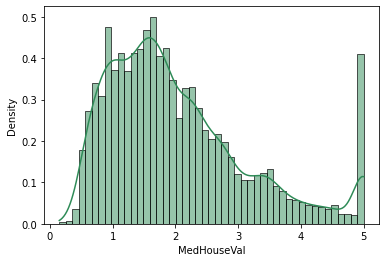

In [9]:
sns.histplot(data=dataset, x=cols[-1], kde=True, stat='density', color='seagreen');

We now pass to the data-splitting. We first normalise the data and then, since this is a relatively large dataset, split it by the 80:20 ration into a train and test set. Finally, we add a column for the intercept so that the model $y=Ax+b$ may be succinctly rewritten as $y=Ax$

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Normalise
df = pd.DataFrame(StandardScaler().fit_transform(dataset),columns = dataset.columns)
X = np.asarray(df)[:,0:len(cols) - 1]
y = np.asarray(df)[:,len(cols) - 1]

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

#Introduce intercept
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)

#Adjust
cols = list(np.delete(cols, -1))
cols.append('Intercept')

n, d = X_train.shape

## Question 2


Here we consider the minimisation problem 
$$
    \min_{{x} \in \mathbb{R}^d} f({x})
$$
where 
$$ f(x)= \frac{1}{2n} \|{A} {x} - {y}\|^2 + \frac{\lambda}{2} \|x\|^2_2 = \frac{1}{n}\sum_{i=1}^{n} (Ax_i - y_i)^2 + \lambda\sum{x_{i}^2}$$
and the gradient writes as
$$ \nabla{f} = \frac{1}{n}A^{T}(Ax-y) + \lambda x

- _Implement gradient descent for regression ($\ell_2$-loss) with a small ridge penalty._

In [11]:
gradient_ridge = lambda X, err, theta, lmbda: (1/X.shape[0]) * np.dot(X.T, err) + 1*lmbda*theta
loss = lambda X, y, theta: np.mean((np.dot(X,theta)-y)**2)

def GD_ridge(X, y, niter, step=0.001, penalty=0):
    theta = np.zeros(X.shape[1])
    loss_evol = np.zeros(niter)
    for i in range(niter):
        error_k = np.dot(X, theta) - y
        grad = gradient_ridge(X, error_k, theta, penalty)
        theta = theta - step* (grad / np.linalg.norm(grad))
        loss_evol[i] = loss(X, y, theta)
    return theta, loss_evol


In [12]:
niter = 150
steps = [1/10**i for i in range(1, 5)]
penalty = 1e-5
loss_evol = np.zeros((niter, len(steps)))
theta = np.zeros((len(steps), X_train.shape[1]))

for i in range(len(steps)):
    s = steps[i]
    th, loss_evol[:, i] = GD_ridge(X_train, y_train, niter, step=s, penalty=penalty)
    theta[i] = th[-1]

- _Display the convergence rate on the training loss for several fixed step sizes._

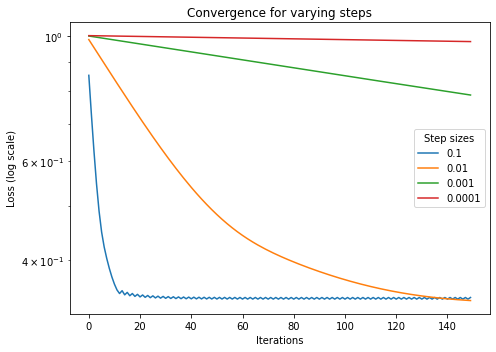

In [13]:
loss_evol = pd.DataFrame(loss_evol, columns=steps)

plt.clf
plt.figure(figsize=(7,5), tight_layout=True)
plt.plot(loss_evol, label=steps)
plt.xlabel("Iterations")
plt.ylabel("Loss (log scale)")
plt.yscale('log')
plt.title('Convergence for varying steps')
plt.legend(title='Step sizes');

We consider 5 different step sizes $\alpha$ for a penalty of $\lambda=10^{-5}$. When this optimisation problem has been regularised as above, we know that the system has a unique solution and is guaranteed to converge for a step size that is small enough. 

We see above that a step size that is too small inhibits the speed of convergence. As the step sizes decrease, the method converges faster and for a step size of 0.1, the method is close to convergence after only approximately 30 iterations.

### Question 3: 
_What is the optimal step choice ? How does this compare with the theory ?_

We run GD for a number of different step sizes and plot the resulting train and test loss.

In [24]:
niter = 200
step = np.linspace(start=0.005, stop=0.3, num=50)
penalty = 0.00

loss_evolution = np.zeros(len(step))
theta = np.zeros((X_train.shape[1], len(step)))
train_loss = np.zeros(len(step))
test_loss = np.zeros(len(step))

for i in range(len(step)):
    s = step[i]
    theta[:, i], loss_evolution = GD_ridge(X_train, y_train, niter, s, penalty)
    train_loss[i] = loss_evolution[-1]
    test_loss[i] = loss(X_test, y_test, theta[:, i])

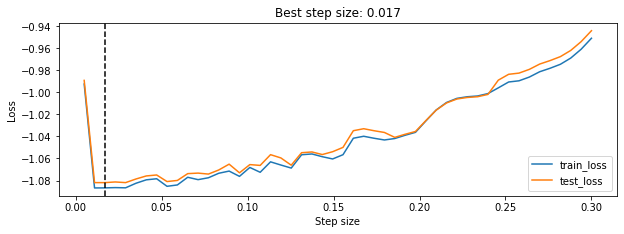

In [26]:
min_i = test_loss.argmin()

plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(step, np.log(train_loss), label='train_loss')
plt.plot(step, np.log(test_loss), label= 'test_loss')
plt.axvline(x=step[min_i], linestyle='dashed', c='k')
plt.xlabel("Step size")
plt.ylabel("Loss")
plt.title(f'Best step size: {np.round(step[min_i], 4)}')
plt.legend();

The best step size seems to occur at $\alpha=0.017$

The theory states that the optimal step size is at $\alpha=\frac{2}{\|X\|}$ where $\|\cdot\|$ represents the matrix norm. For this problem:

In [16]:
tau = 2/np.linalg.norm(X_train,2)
print(f'tau_opt={np.round(tau,4)}')

tau_opt=0.0112


The optimal step choice should be 0.012, which corresponds relatively well with the observed result of 0.017

## Question 4
_Show the regression performance on the test set as the ridge penalty changes._ 

We set the step size to the value determined above and repeat the procedure as with Question 3

In [17]:
niter = 100
penalties = np.linspace(start=0.00, stop=0.03, num=50)
step = 0.0112

loss_evolution = np.zeros(len(penalties))
theta = np.zeros((X_train.shape[1], len(penalties)))
train_loss = np.zeros(len(penalties))
test_loss = np.zeros(len(penalties))

for i in range(len(penalties)):
    p = penalties[i]
    theta[:, i], loss_evolution = GD_ridge(X_train, y_train, niter, step, penalty=p)
    train_loss[i] = loss_evolution[-1]
    test_loss[i] = loss(X_test, y_test, theta[:, i])


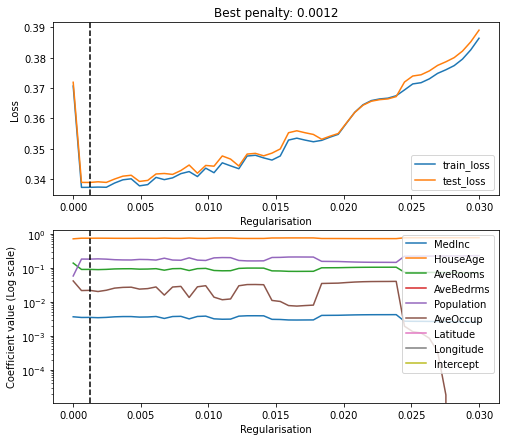

In [30]:
min_i = test_loss.argmin()

plt.figure(figsize=(8, 7))
plt.subplot(2,1,1)
plt.plot(penalties, train_loss, label='train_loss')
plt.plot(penalties, test_loss, label= 'test_loss')
plt.axvline(x=penalties[min_i], linestyle='dashed', c='k')
plt.xlabel("Regularisation")
plt.ylabel("Loss")
plt.title(f'Best penalty: {np.round(penalties[min_i],4)}')
plt.legend();

plt.subplot(2,1,2)
plt.plot(penalties, theta.T, label=cols)
plt.legend(loc='upper right')
plt.axvline(x=penalties[min_i], linestyle='dashed', c='k')
plt.xlabel("Regularisation")
plt.ylabel("Coefficient value (Log scale)")
plt.yscale('log');

And the coefficients associated are

In [19]:
dict(zip(cols, np.round(theta[:,min_i],4)))

{'MedInc': 0.0035,
 'HouseAge': 0.7289,
 'AveRooms': 0.1248,
 'AveBedrms': -0.132,
 'Population': 0.1078,
 'AveOccup': 0.0352,
 'Latitude': -0.2112,
 'Longitude': -0.4033,
 'Intercept': -0.3272}

Let us now consider the predictive performance

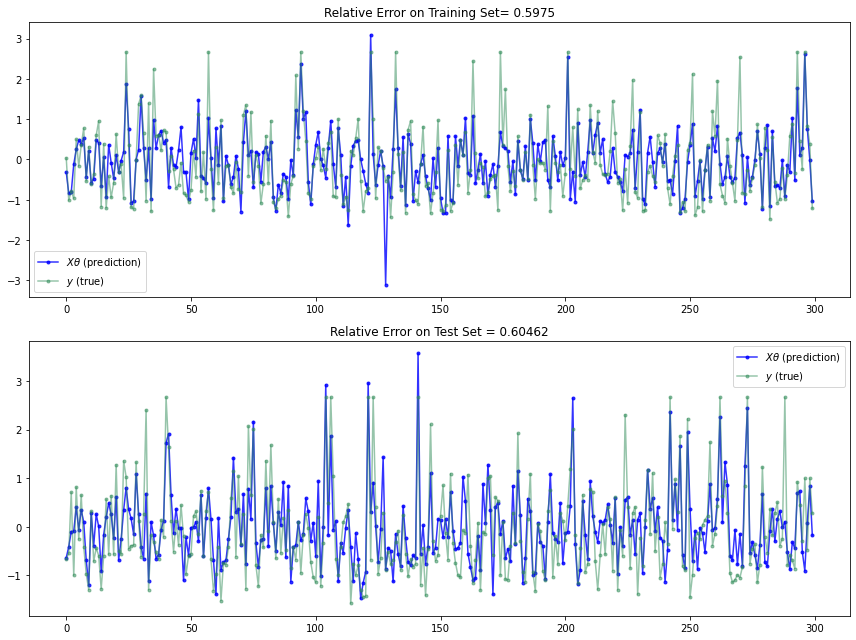

In [20]:
numpredictions=300
thstar = theta[:,min_i]

plt.clf
plt.figure(figsize= (12,9), tight_layout=True)
plt.subplot(2, 1, 1)
plt.plot( X_train.dot(thstar)[0:numpredictions], 'b.-', alpha=0.8)
plt.plot( y_train[0:numpredictions], '.-', c='seagreen', alpha=0.5)
rel_err = np.linalg.norm(X_train.dot(thstar) - y_train, 2) / np.linalg.norm(y_train, 2)
plt.title(f'Relative Error on Training Set= {np.round(rel_err, 4)}')
plt.legend((r'$X\theta$ (prediction)', r'$y$ (true)'))

plt.subplot(2, 1, 2)
plt.plot( X_test.dot(thstar)[0:numpredictions], 'b.-', alpha=0.8)
plt.plot( y_test[0:numpredictions], '.-', c='seagreen', alpha=0.5)
rel_err = np.linalg.norm(X_test.dot(thstar) - y_test, 2) / np.linalg.norm(y_test, 2)
plt.title(f'Relative Error on Test Set = {np.round(rel_err, 5)}')
plt.legend((r'$X\theta$ (prediction)', r'$y$ (true)'));

The relative error on both the test and train set are comparable up to 2 significant digits and although not very close to 0, seems reasonable. 

Consider also a histogram and kernel density plot of the observed and predicted lables $y^*$ and $\hat{y}$ below.

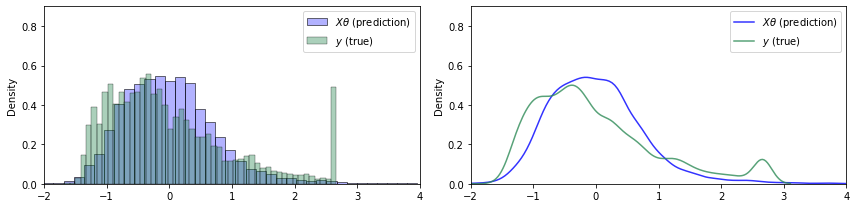

In [21]:
import seaborn as sns
plt.figure(figsize= (12,3), tight_layout=True)
plt.subplot(1,2,1)
sns.histplot(x=X_train.dot(thstar), kde=False, stat='density', bins=50, color='b', alpha=0.3)
sns.histplot(x=y_train, kde=False, stat='density', bins=50, color='seagreen', alpha=0.4);
plt.xlim(-2, 4)
plt.ylim(0, 0.9)
plt.legend((r'$X\theta$ (prediction)', r'$y$ (true)'));

plt.subplot(1,2,2)
sns.kdeplot(x=X_train.dot(thstar), color='b', alpha=0.8)
sns.kdeplot(x=y_train, color='seagreen', alpha=0.8)
plt.xlim(-2, 4)
plt.ylim(0, 0.9)
plt.legend((r'$X\theta$ (prediction)', r'$y$ (true)'));

We observe that these follow roughly the same distribution, indicating that long-term predictions should be statistically consistent.